Importamos las librerias. Algunas son para el uso de la GPU, otras son para el proyecto

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import subprocess
import cv2
from tensorflow.keras.callbacks import EarlyStopping



In [4]:
import tensorflow as tf
# Verificar si TensorFlow detecta GPU
if tf.config.experimental.list_physical_devices('GPU'):
    print('GPU detectada:')
    for device in tf.config.list_physical_devices('GPU'):
        print(device)
else:
    print('No se detectó GPU. Se utilizará la CPU.')

GPU detectada:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Para que el programa utilice la VRAM que tiene el sistema y no la RAM de la computadora

In [5]:
def get_gpu_memory():
    """Returns the total memory of the GPU in MB"""
    try:
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.total", "--format=csv,nounits,noheader"], 
            encoding='utf-8')
        return int(result.strip())
    except Exception as e:
        print("Error al obtener la información de la memoria de la GPU:", e)
        return None

# Obtener la cantidad de memoria VRAM disponible en la GPU
total_memory_mb = get_gpu_memory()
if total_memory_mb is not None:
    total_memory_gb = total_memory_mb / 1024
    print("Cantidad total de memoria VRAM en la GPU:", total_memory_gb, "GB")
    
    # Configurar TensorFlow para limitar el uso de memoria GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            # Limitar la memoria GPU al máximo disponible
            tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No se pudo obtener la información de la memoria de la GPU.")

Cantidad total de memoria VRAM en la GPU: 6.0 GB


Leer la base de datos creada con anterioridad y ver su contenido

In [6]:
df = pd.read_hdf('BD_Emotions_Gray.h5')

In [7]:
df.head()

,Imagen,Caracteristicas,Rostro,Etiqueta
0,"[[154, 157, 156, 157, 158, 159, 157, 157, 159,...","[[[59, 64], [59, 72], [61, 80], [62, 88], [64,...","[[167, 166, 166, 18, 14, 35, 102, 18, 24, 39, ...",excited
1,"[[156, 155, 156, 156, 159, 156, 156, 157, 158,...","[[[57, 63], [58, 71], [59, 79], [60, 87], [62,...","[[167, 151, 9, 12, 107, 112, 19, 30, 40, 42, 8...",excited
2,"[[172, 171, 173, 171, 172, 172, 173, 172, 172,...","[[[60, 81], [60, 90], [61, 98], [62, 106], [64...","[[51, 5, 8, 81, 100, 105, 104, 107, 111, 123, ...",excited
3,"[[171, 168, 168, 170, 171, 169, 169, 170, 170,...","[[[62, 86], [62, 92], [64, 97], [65, 102], [67...","[[16, 15, 12, 17, 23, 36, 84, 121, 132, 141, 1...",excited
4,"[[180, 181, 181, 181, 183, 182, 181, 182, 182,...","[[[58, 75], [59, 82], [60, 89], [62, 96], [64,...","[[4, 5, 9, 25, 85, 107, 119, 126, 130, 134, 13...",excited


Separamos las caracteristicas y etiquetas

In [8]:
# Separar las características y etiquetas
X = np.array(df['Rostro'])
y = df['Etiqueta']

Verificamos el formato, que sea ideal para la CNN

In [9]:
print(df['Imagen'].values[0].shape)
print(df['Rostro'].values[1].shape)

(150, 150)
(62, 62)


Dado que el formato de rostro puede ser menor o mayor medida, hay que adaptar todos los datos a un formato. En este caso lo escalamos a 150x150

In [10]:
for i in range(X.shape[0]):
    X[i] = np.array(Image.fromarray(X[i]).resize((150,150)))
    X[i] = np.expand_dims(X[i], axis=-1)

Verificamos el formato 

In [11]:
print(X[0].shape)

(150, 150, 1)


Codificamos el formato de las etiquetas para que estén en 0,1,2,3,4,5...

In [12]:
# Codificar las etiquetas
etiquetas = y.unique()
y_encoded = pd.Categorical(y, categories=etiquetas).codes
print(y_encoded)

[0 0 0 ... 2 2 2]


Hacemos los datos de entrenamiento y los de prueba

In [13]:

# Dividir el dataset en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


Transformar las etiquetas a one_hot. Dependiendo la posición del numero es la etiqueta 

In [14]:
# Convertir las etiquetas a formato one-hot
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
clases_originales = df['Etiqueta'].unique()
print(y_val_one_hot)
print("Clases originales:", df['Etiqueta'].unique())

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
Clases originales: ['excited' 'engaged' 'bored']


Distribución visual de las etiquetas y su clasificacion

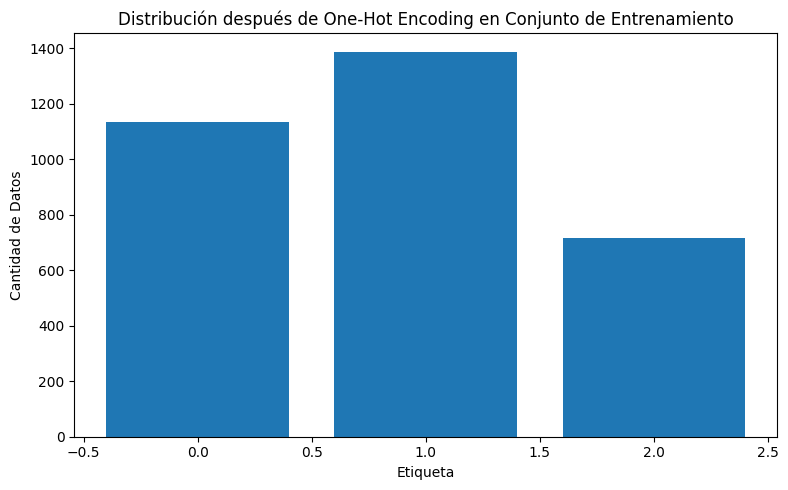

In [15]:
# Visualizar la distribución después de convertir las etiquetas a one-hot
plt.figure(figsize=(8, 5))
plt.bar(np.unique(y_train_one_hot.argmax(axis=1)), np.bincount(y_train_one_hot.argmax(axis=1)), align='center')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución después de One-Hot Encoding en Conjunto de Entrenamiento')
plt.tight_layout()
plt.show()

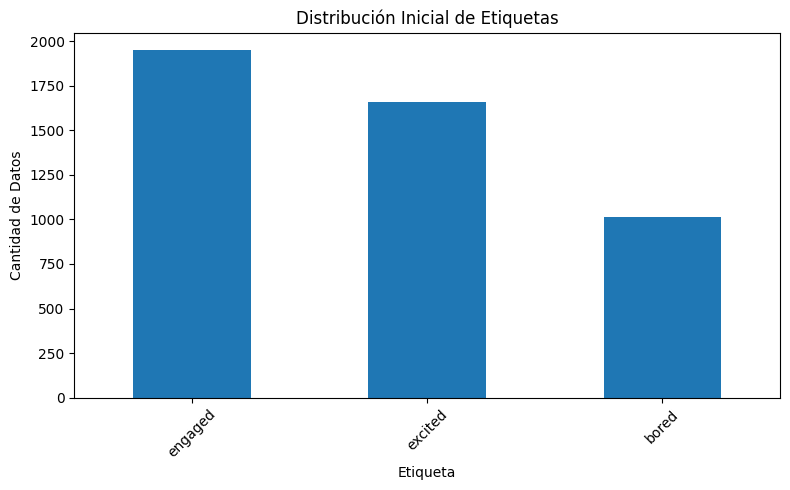

In [16]:
# Visualizar la distribución inicial de etiquetas
plt.figure(figsize=(8, 5))
df['Etiqueta'].value_counts().plot(kind='bar')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución Inicial de Etiquetas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Normalizamos los datos de entrenamiento y los de valores para verificar en numpy array

In [17]:
# Convertir las imágenes a arrays numpy y normalizarlas
X_train = np.array([np.array(img) for img in X_train])
X_val = np.array([np.array(img) for img in X_val])

Todos los datos de entrenamiento los ponemos en tipo flotante 32 y lo dividimos en 255 (que es formato de imagen), esto para normalizar del 0 al 1

In [18]:
# Normalizar las imágenes dividiendo por 255.0
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

Generamos infinidad de imagenes (Muchas imagenes. No son infinitas). Definimos los patrones para generar más imagenes y que el modelo no se sobre ajuste

In [19]:
# Definir el generador de imágenes para aumentar el dataset de entrenamiento
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



Aqui lo aumentamos.

In [20]:
# Aumentar el dataset de entrenamiento utilizando el generador de imágenes
train_generator = datagen.flow(X_train, y_train_one_hot, batch_size=28)


Todo el modelo definido

In [21]:
# Definir el modelo de red neuronal convolucional (CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(etiquetas), activation='softmax')  # Capa de salida con activación softmax
])


Compilamos el modelo.

In [22]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Entrenamos el modelo

In [23]:
# Definir Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [ ]:
# Entrenar el modelo con el callback de TensorBoard
with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
                    epochs=30,
                    validation_data=(X_val, y_val_one_hot),
                    verbose=1,
                    callbacks=[early_stopping]
                    )


Epoch 1/30


Guardamos el modelo

In [ ]:
# Guardar el modelo
model.save('modelo_cnn_gray_v3.h5')

Obtenemos predicciones del conjunto de validacion

In [ ]:
# Obtener las predicciones del conjunto de validación
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

Tabla graficamente de la precision y perdida del modelo a partir de las epocas

In [ ]:
# Mostrar la precisión y pérdida del modelo
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión del Modelo')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida del Modelo')

plt.tight_layout()
plt.show()

Matriz de confusion

In [ ]:
# Calcular la matriz de confusión
conf_mat = confusion_matrix(np.argmax(y_val_one_hot, axis=1), y_pred_classes)

Visualizacion de la matriz de confusion mediante mapa de calor

In [ ]:
# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Verdaderas')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()